# Introduction to WaveNet
## Jonathan Balaban

WaveNet is a powerful new predictive technique that uses multiple Deep Learning (DL) strategies from Computer Vision (CV) and Audio Signal Processing models and applies them to longitudinal (time-series) data. It was created by researchers at London-based artificial intelligence firm [DeepMind](https://deepmind.com), and currently powers [Google Assistant voices](https://assistant.google.com).

We'll explore WaveNet and how it works, but first dive into data prep, current high-performance models (as a baseline, Facebook Prophet), and then compare results!

>run this full line in bash, as one line:

`conda create -n wavenet python=3.7 pandas numpy seaborn matplotlib jupyter keras`

>then install Facebook Prophet:

`source activate wavenet; conda install -c conda-forge fbprophet`

# Data Setup

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [45]:
# load stocks
aapl_raw = pd.read_csv('./data/AAPL.csv')
msft_raw = pd.read_csv('./data/MSFT.csv')
sp500_raw = pd.read_csv('./data/^GSPC.csv')
nsdq_raw = pd.read_csv('./data/^IXIC.csv')

In [46]:
aapl_raw.info()

# we need to set date as datetime object and index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4865 entries, 0 to 4864
Data columns (total 7 columns):
Date         4865 non-null object
Open         4865 non-null float64
High         4865 non-null float64
Low          4865 non-null float64
Close        4865 non-null float64
Adj Close    4865 non-null float64
Volume       4865 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 266.1+ KB


In [47]:
# set index
aapl_raw.index = pd.to_datetime(aapl_raw.Date).dt.date
msft_raw.index = pd.to_datetime(msft_raw.Date).dt.date
sp500_raw.index = pd.to_datetime(sp500_raw.Date).dt.date
nsdq_raw.index = pd.to_datetime(nsdq_raw.Date).dt.date

In [48]:
# check
aapl_raw.head()

# looks good!

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2000-01-03,2000-01-03,3.745536,4.017857,3.631696,3.997768,2.665724,133949200
2000-01-04,2000-01-04,3.866071,3.950893,3.613839,3.660714,2.440975,128094400
2000-01-05,2000-01-05,3.705357,3.948661,3.678571,3.714286,2.476697,194580400
2000-01-06,2000-01-06,3.790179,3.821429,3.392857,3.392857,2.262367,191993200
2000-01-07,2000-01-07,3.446429,3.607143,3.410714,3.553571,2.369532,115183600


In [49]:
# rename Adj Close to AC, get rid of pesky spacing
aapl_raw['aAC'] = aapl_raw['Adj Close']
msft_raw['mAC'] = msft_raw['Adj Close']
sp500_raw['sAC'] = sp500_raw['Adj Close']
nsdq_raw['nAC'] = nsdq_raw['Adj Close']

In [50]:
# specify Volume
aapl_raw['aV'] = aapl_raw['Volume']
msft_raw['mV'] = msft_raw['Volume']
sp500_raw['sV'] = sp500_raw['Volume']
nsdq_raw['nV'] = nsdq_raw['Volume']

>Based on [this article](https://finance.zacks.com/adjusted-closing-price-vs-closing-price-9991.html) and others, let's use Adj Close as our series.

In [51]:
# calculate MACD (a key trading metric, and helpful exogenous variable)
#aapl_raw['MACD'] = (aapl_raw.AC.ewm(span=12).mean() - aapl_raw.AC.ewm(span=26).mean())

>[MACD is often used by investors as a buy/sell indicator](https://www.investopedia.com/terms/m/macd.asp), so it should help track patterns and trend changes!

In [52]:
# good, drop Date and everything but AC and Volume
aapl = aapl_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
msft = msft_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
sp500 = sp500_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
nsdq = nsdq_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
aapl.head()

,aAC,aV
Date,,
2000-01-03,2.665724,133949200
2000-01-04,2.440975,128094400
2000-01-05,2.476697,194580400
2000-01-06,2.262367,191993200
2000-01-07,2.369532,115183600


In [53]:
aapl.describe().round(2)

,aAC,aV
count,4865.00,4.865000e+03
mean,47.39,1.179476e+08
std,57.15,9.905649e+07
min,0.62,9.835000e+06
25%,3.01,5.076120e+07
50%,17.91,9.108610e+07
75%,86.43,1.539104e+08
max,230.28,1.855410e+09


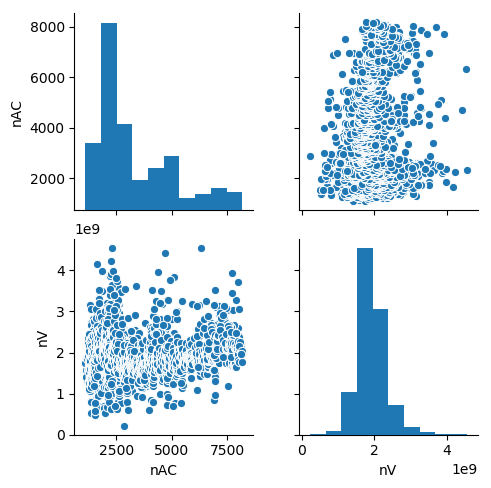

In [54]:
sns.pairplot(nsdq);

We can note a few things from the EDA above:
- No NULLs
- Inverse exponential relationship between AC and Volume?
- Right skew in price

There's an important consideration also: **stock splits!**

Apple's stock has split four times since the company went public. The stock split on a 7-for-1 basis on June 9, 2014 and split on a 2-for-1 basis on February 28, 2005, June 21, 2000, and June 16, 1987.

Let's filter to the 2014 and 2005 weeks and see what happened:

In [55]:
# join dataframes
df = pd.concat([sp500, nsdq, msft, aapl], axis=1)
df.head()

,sAC,sV,nAC,nV,mAC,mV,aAC,aV
Date,,,,,,,,
2000-01-03,1455.219971,931800000,4131.149902,1510070000,42.115314,53228400,2.665724,133949200
2000-01-04,1399.420044,1009000000,3901.689941,1511840000,40.692646,54119000,2.440975,128094400
2000-01-05,1402.109985,1085500000,3877.540039,1735670000,41.121727,64059600,2.476697,194580400
2000-01-06,1403.449951,1092300000,3727.129883,1598320000,39.744217,54976600,2.262367,191993200
2000-01-07,1441.469971,1225200000,3882.620117,1634930000,40.263588,62013600,2.369532,115183600


# Statistics

# FB Prophet

In [56]:
from fbprophet import Prophet

# pull only close price and set up dataframe for prophet
aapl_fb = aapl
aapl_fb['ds'] = aapl_fb.index
aapl_fb = aapl_fb.rename(columns={'aAC': 'y'})

In [57]:
aapl_fb.head()

,y,aV,ds
Date,,,
2000-01-03,2.665724,133949200,2000-01-03
2000-01-04,2.440975,128094400,2000-01-04
2000-01-05,2.476697,194580400,2000-01-05
2000-01-06,2.262367,191993200,2000-01-06
2000-01-07,2.369532,115183600,2000-01-07


In [58]:
# fit model without final thirty periods
fbm = Prophet(weekly_seasonality='auto', daily_seasonality=False, seasonality_mode='additive')

fbm.fit(aapl_fb.iloc[:-30,:]);

# create future dataset
future = fbm.make_future_dataframe(periods=30, freq='D')
future.tail()

/Users/jb/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds
4860,2019-04-17
4861,2019-04-18
4862,2019-04-19
4863,2019-04-20
4864,2019-04-21


In [59]:
# check endpoint for train
aapl_fb.iloc[-30,:]

y         188.74
aV      43845300
ds    2019-03-25
Name: 2019-03-25, dtype: object

In [60]:
forecast = fbm.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
4860,2019-04-17,193.527900,181.425030,205.107742
4861,2019-04-18,193.559614,181.819582,205.502778
4862,2019-04-19,193.560676,181.573884,205.560967
4863,2019-04-20,193.885824,182.592745,206.579699
4864,2019-04-21,193.970958,183.192029,205.659439


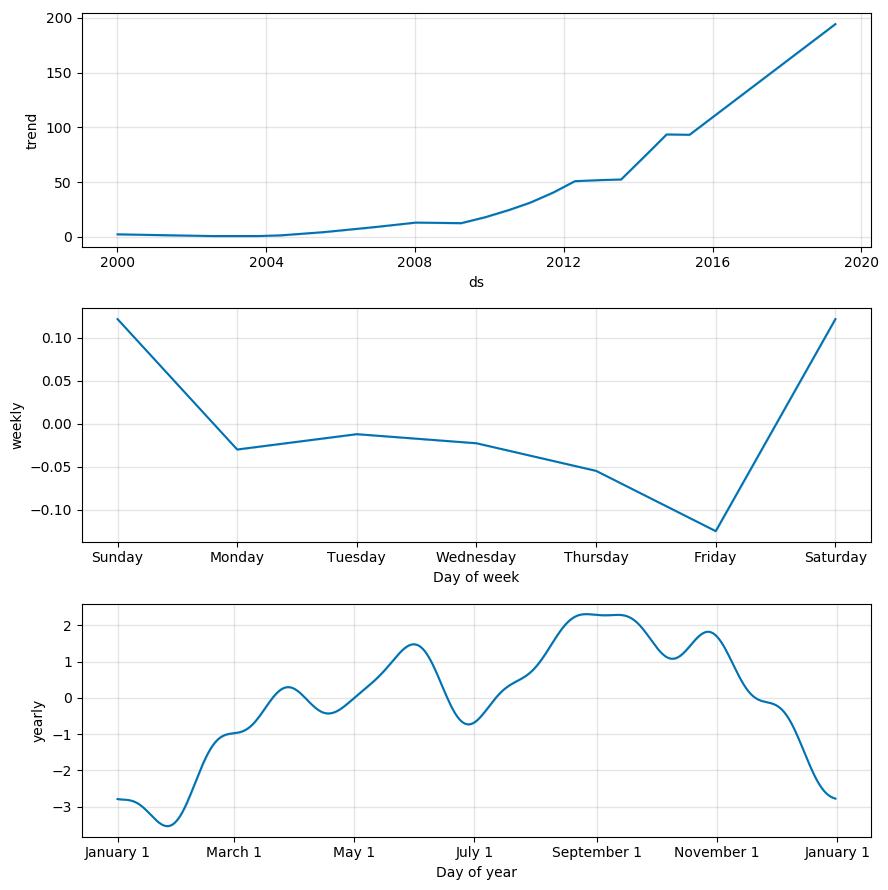

In [61]:
fbm.plot_components(forecast);

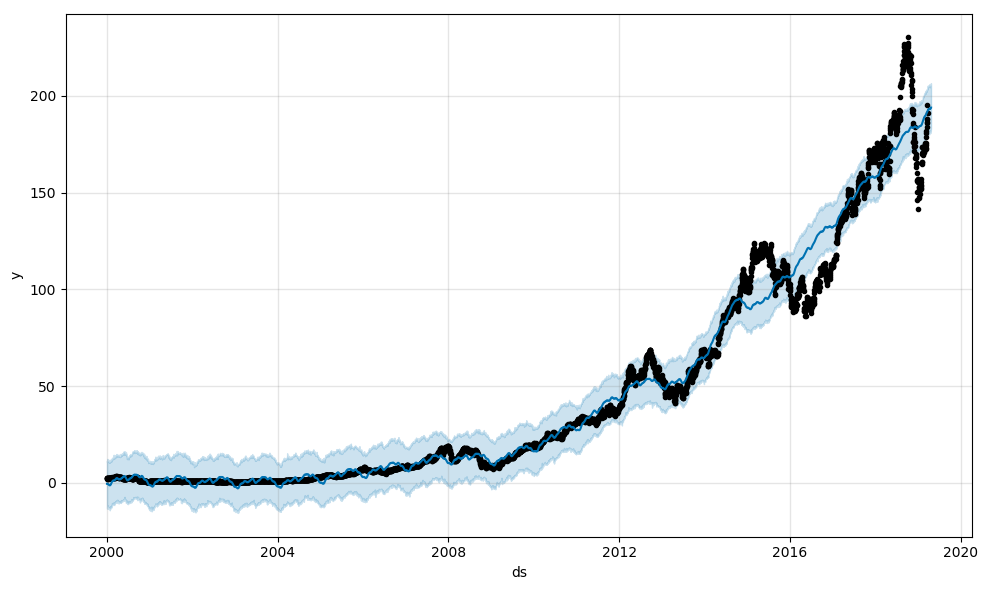

In [62]:
pred_plot = fbm.plot(forecast)

In [63]:
# calculate MAE

diffs = np.absolute(aapl_fb.y[-30:].values - forecast.yhat[-30:].values)

diffs.mean() # this is our metric for comparison

8.043323964154752

# WaveNet Theory

### Dilated Causal Convolution Layers
The model architecture we will build is a variant of the [WaveNet model](https://deepmind.com/blog/wavenet-generative-model-raw-audio/), but optimized for sequence data.

The **dilated causal convolution layer** is the default building block; Joe Eddy has a fantastic breakdown of [how it works here](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb) and [in his blog here](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/). In a nutshell, these layers (borrowed and modified from CNNs) are designed to learn detailed patterns from recent stock price movements, but also big-picture trends and cycles from months and years ago.

![dilated convolutions](./images/WaveNet_dilatedconv.png)

### More building blocks:

We need to add a few other techniques:

![blocks](./images/WaveNet_residblock.png)

### **Gated Activations**

In the boxed portion of the architecture diagram above, note the dilated convolution splits into two branches that recombine via element-wise multiplication. This is a **gated activation unit**:
- **tanh:** activation branch is a learned (model optimized) filter
- **sigmoid:** activation branch is a learned gate that controls flow from the *tanh* filter (just like LSTM gates)

### Skip Connections

In fully-connected NNs, a neuron takes inputs from all neurons in the previous layer: early layers establish later ones via a hierarchy of intermediate computations. This allows NNs to build complex interactions of raw inputs/signals.

But... what if raw inputs are directly useful for prediction, and we want them to directly influence the output? **Skip connections** allow outputs of any layer to bypass multiple future layers and skip influence dilution! Keras allows us to store the tensor output of each convolutional block - in addition to passing it through further layers - with `skips.append()`. Note how for each block in the stack above, the output from the gated activations joins the set of skip connections. How much or how far you do this is a hyper-parameter that depends on your data and model structure!

### Residual Connections

![CNN_skips](./images/CNN_skips.png)

**Residual connections** are similar to skip connections: think of them as consistenly-available short layer skips! We'll use a one-layer skip for our model, but it's also a hyper-parameter. Why they help is mysterious, but it's most likely due to helping with the [Vanishing or Exploding Gradient](https://medium.com/learn-love-ai/the-curious-case-of-the-vanishing-exploding-gradient-bf58ec6822eb) obstacle in backpropagation. This becomes more important with larger models, but I'll show you the implementation in a smaller setting for educational purposes.

> Note: the diagram's *1x1 convolutions* are basically time-distributed fully connected layers; this allows us to use CNN language for our architecting!

![XKCD](./images/XKCD.png)

## Data Setup

First, Keras needs us to convert our series into `numpy` arrays. As we prep our data, we should have a partition strategy to validate and test our model's results. [Artur Suilin](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md) created a visualization of the **walk-forward validation** strategy that serves as a best practice:

![walk-forward validation](./images/ArturSuilin_validation.png)

Let's use this approach as we parse, learn, and validate our data!

In [64]:
# transpose to fit structure below
#aapl = aapl[['Volume', 'AC', 'MACD']]
df = df.T

In [65]:
from datetime import timedelta

data_start_date = df.columns[1]
data_end_date = df.columns[-1]

pred_steps = 100
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [66]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

In [67]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2000-01-04 00:00:00 - 2018-10-18 00:00:00
Train prediction: 2018-10-19 00:00:00 - 2019-01-26 00:00:00 

Val encoding: 2000-04-13 00:00:00 - 2019-01-26 00:00:00
Val prediction: 2019-01-27 00:00:00 - 2019-05-06 00:00:00

Encoding interval: 6863
Prediction interval: 100


In [68]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log(series_array)
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log(series_array)
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

# WaveNet Modeling

## Architecture Overview

Let's build our model like so:

* 16 dilated causal convolutional blocks
    * Pre and postprocessing (time distributed) fully connected layers (i.e. convolutions with filter width 1):
        * 16 output units
    * 32 filters of width 2 per block
    * Exponentially increasing dilation rate with a reset (1, 2, 4, 8,... 2^6), two sets
    * Gated activations
    * Residual and skip connections
* 2 fully connected layers to combine skip outputs to final output

In [69]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam

In [70]:
# hyper-parameters
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(7)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gate
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # combine filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract training target at end
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':66})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

In [71]:
# print model architecture
#model.summary()

In [72]:
first_n_samples = 8
batch_size = 2**10
epochs = 100

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]

encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]

decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

In [73]:
model.compile(Adam(), loss='mean_absolute_error')

history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.20)

Train on 6 samples, validate on 2 samples
Epoch 1/100
6/6 [==============================] - 34s 6s/step - loss: 0.6297 - val_loss: 1.5335
Epoch 2/100
6/6 [==============================] - 2s 409ms/step - loss: 0.5523 - val_loss: 1.4427
Epoch 3/100
6/6 [==============================] - 2s 405ms/step - loss: 0.4734 - val_loss: 1.3508
Epoch 4/100
6/6 [==============================] - 2s 408ms/step - loss: 0.3865 - val_loss: 1.2534
Epoch 5/100
6/6 [==============================] - 3s 423ms/step - loss: 0.3071 - val_loss: 1.1332
Epoch 6/100
6/6 [==============================] - 3s 422ms/step - loss: 0.2708 - val_loss: 1.0001
Epoch 7/100
6/6 [==============================] - 3s 430ms/step - loss: 0.3125 - val_loss: 0.9279
Epoch 8/100
6/6 [==============================] - 3s 421ms/step - loss: 0.3452 - val_loss: 0.9312
Epoch 9/100
6/6 [==============================] - 3s 423ms/step - loss: 0.3012 - val_loss: 0.9711
Epoch 10/100
6/6 [==============================] - 3s 422ms/step - l

Epoch 83/100
6/6 [==============================] - 2s 414ms/step - loss: 0.1092 - val_loss: 0.3676
Epoch 84/100
6/6 [==============================] - 2s 405ms/step - loss: 0.1068 - val_loss: 0.3682
Epoch 85/100
6/6 [==============================] - 2s 404ms/step - loss: 0.1082 - val_loss: 0.3610
Epoch 86/100
6/6 [==============================] - 2s 407ms/step - loss: 0.1108 - val_loss: 0.3496
Epoch 87/100
6/6 [==============================] - 2s 412ms/step - loss: 0.1054 - val_loss: 0.3356
Epoch 88/100
6/6 [==============================] - 2s 407ms/step - loss: 0.1091 - val_loss: 0.3223
Epoch 89/100
6/6 [==============================] - 2s 405ms/step - loss: 0.1156 - val_loss: 0.3151
Epoch 90/100
6/6 [==============================] - 3s 422ms/step - loss: 0.1108 - val_loss: 0.3201
Epoch 91/100
6/6 [==============================] - 3s 515ms/step - loss: 0.1099 - val_loss: 0.3222
Epoch 92/100
6/6 [==============================] - 3s 445ms/step - loss: 0.1087 - val_loss: 0.3187


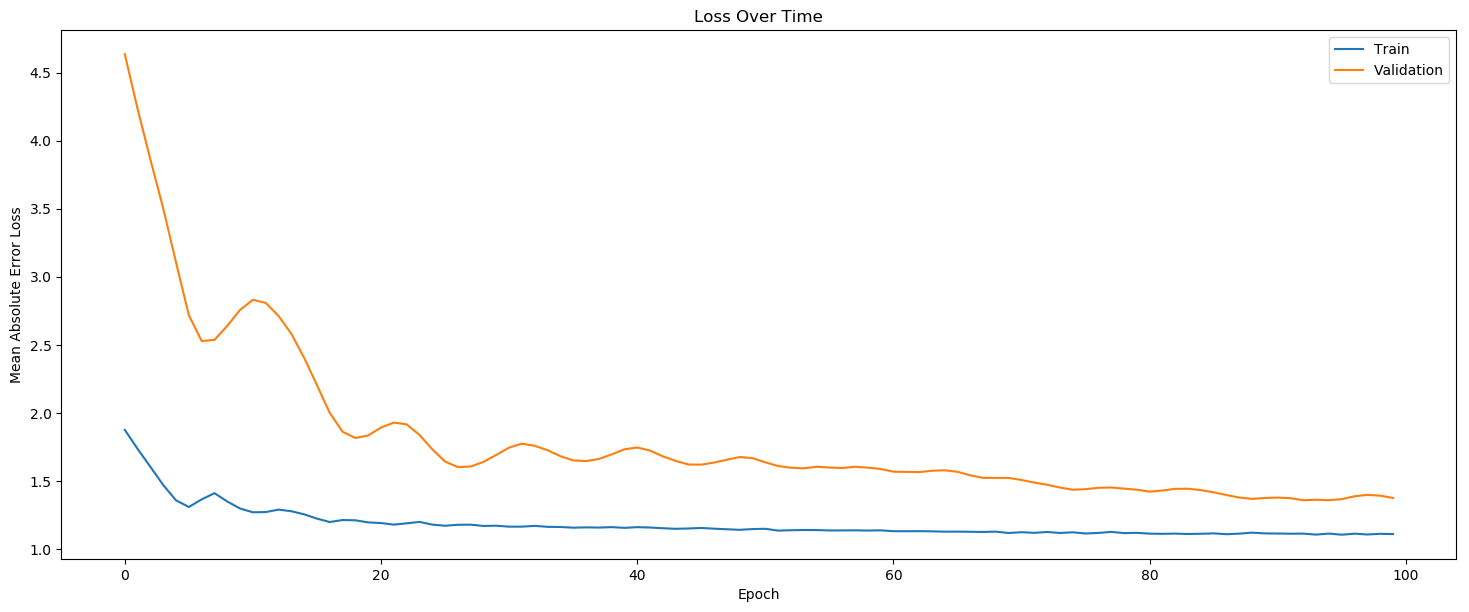

In [74]:
plt.plot(np.exp(history.history['loss']))
plt.plot(np.exp(history.history['val_loss']))

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Validation']);

# Making Predictions

In [75]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [76]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [77]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)  
    target_series = decoder_target_data[sample_ind,:,:].reshape(-1,1)
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    #plt.figure(figsize=(10,6))   

    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps-31),target_series,color='green')
    plt.plot(range(x_encode,x_encode+pred_steps-31),pred_series[:69],color='red',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [78]:
df.index

Index(['sAC', 'sV', 'nAC', 'nV', 'mAC', 'mV', 'aAC', 'aV'], dtype='object')

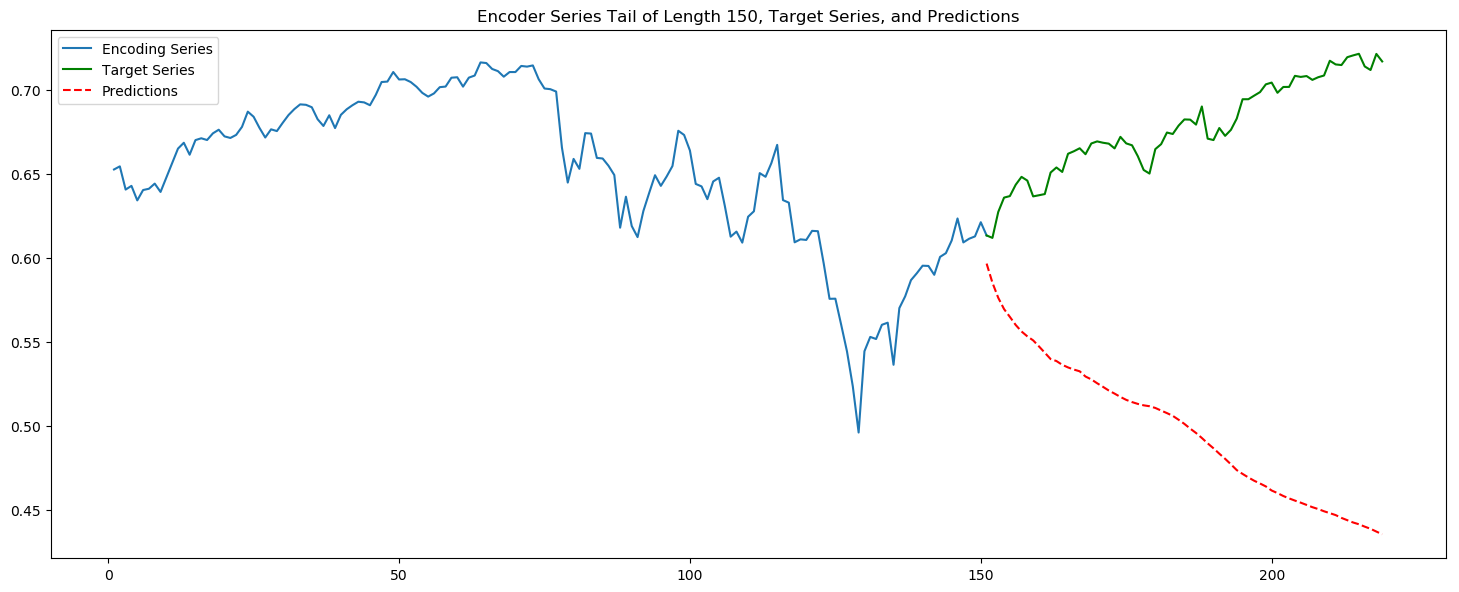

In [79]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=0, enc_tail_len=150)

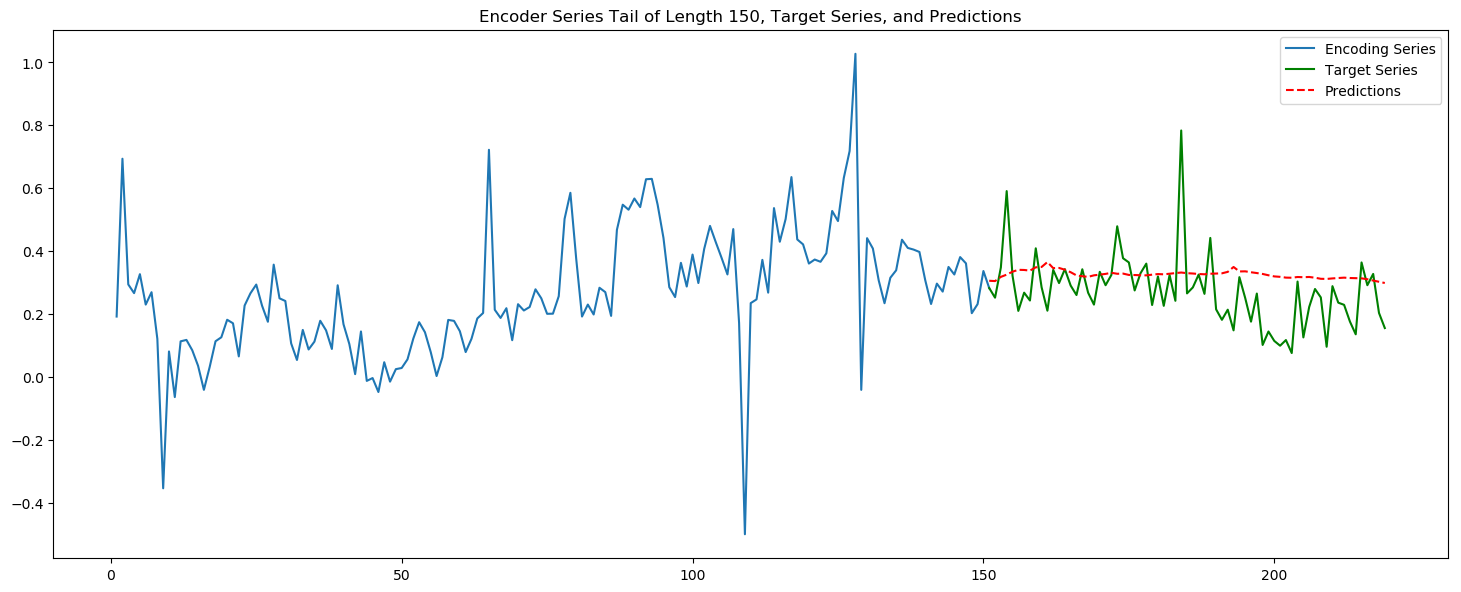

In [80]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=1, enc_tail_len=150)

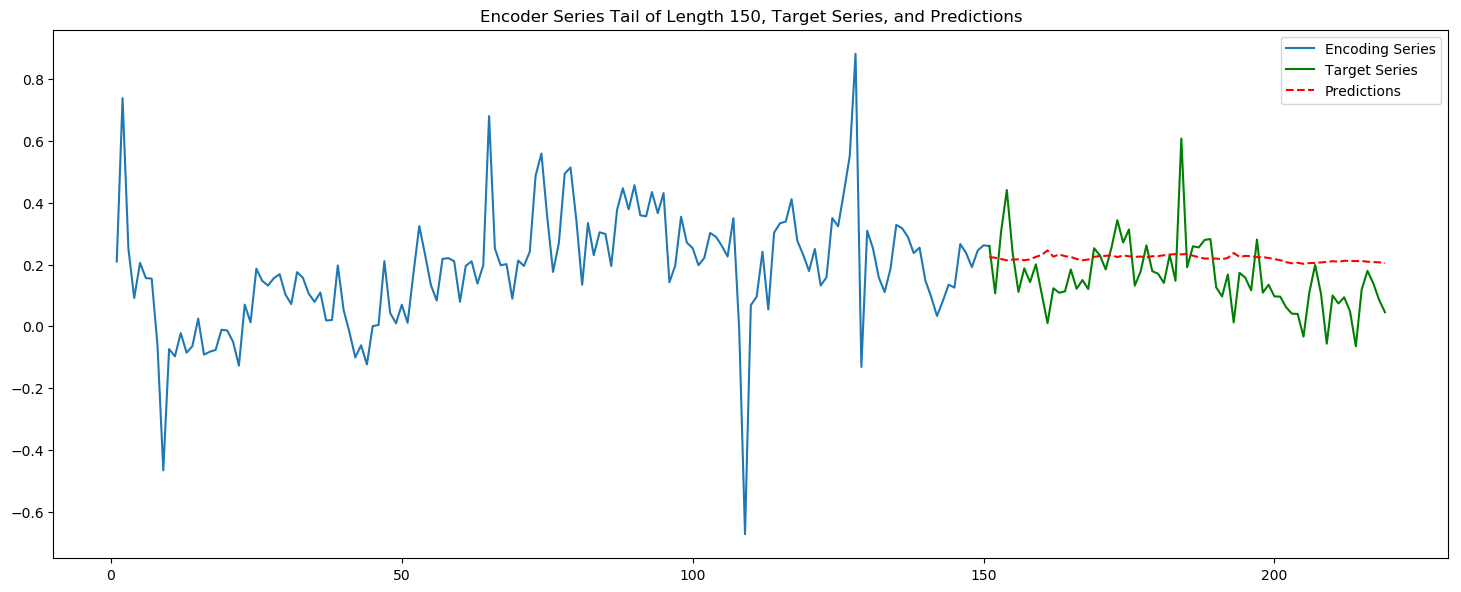

In [82]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=3, enc_tail_len=150)

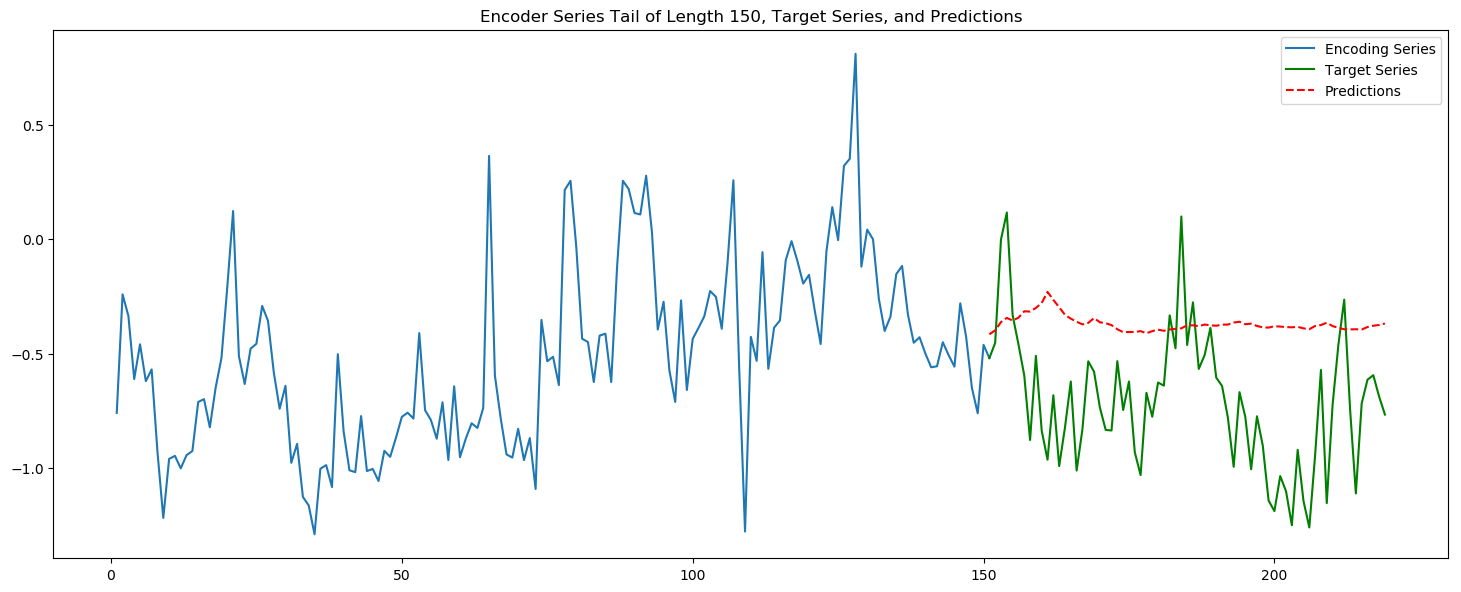

In [84]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=5, enc_tail_len=150)

# Additional Resources

Many thanks to my amazing colleague [Joe Eddy](https://www.linkedin.com/in/joseph-eddy-178425129/) for his informative blog posts on WaveNet:
- [Time Series Forecasting with Convolutional Neural Networks - a Look at WaveNet](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/)
- [Time Series Forecasting with Convolutional Neural Networks - Further Exploration of WaveNet](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv2/)
- Optional context: [Forecasting with Neural Networks - An Introduction to Sequence-to-Sequence Modeling Of Time Series](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_intro/)


## WaveNet Official
- [Blog on audio applications](https://deepmind.com/blog/wavenet-generative-model-raw-audio/)
- [Voice showcase](https://cloud.google.com/text-to-speech/docs/wavenet)
- [Paper](https://arxiv.org/abs/1609.03499)
- [Wiki](https://en.wikipedia.org/wiki/WaveNet)